# Large-scale L-BFGS using MapReduce

*Eléments logiciels pour le traitement des données massives*

Léa Bresson - Kolia Iakovlev 

### Table of content

[1. Introduction](#pb)<br>
[2. The logistic function](#fct)<br>
[3. Generate a dataset](#data)<br>
[4. L-BFGS with scipy](#sc)<br>
[5. L-BFGS with MapReduce](#algo1)<br>
[6. VL-BFGS with MapReduce](#algo2)<br>
[7. Conclusion](#conc)<br>

In [1]:
# Imports
sc = SparkContext.getOrCreate()
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
import random as random
import time
# to embed figures in the notebook
%matplotlib inline

<a id='pb'></a>
## 1. Introduction

The **Limited-memory BFGS** (L-BFGS) has been a very popular algorithm for parameter estimation in machine learning since 1980s. The L-BGFS is an iterative method for solving unconstrained nonlinear optimization problems; it belongs to quasi-Newton methods. For such problems, a necessary condition for optimality is that the gradient be zero. 




More precisely, Newton method is a method used to find the zeros of a differentiable non linear function $g$, x such that $g(x) = 0$, where $g : \mathbb{R^n} \rightarrow \mathbb{R^n}$. Given a starting point $x_0$, Newton method consists in iterating: 
$$ x_{k+1} = x_k - g'(x_k)^{-1}g(x_k) $$ where $g'(x)$ is the derivative of $g$ at point $x$. 
Applying this method to the optimizaton problem $ \min_{x \in \mathbb{R}^n} f(x)$ consists in setting $g(x) = \nabla f(x)$, i.e. looking for stationnary points.  The iterations read: 
$$x_{k+1}  = x_k - \nabla^2 f(x_k)^{-1} \nabla f(x_k)  .$$

A quasi-Newton method reads :
$$x_{k+1}  = x_k - p_k * B_k \nabla f(x_k) .$$
where $B_k$ is a matrix which aims to approximate the inverse of the Hessian of $f$ at $x_k$. The BFGS algorithms uses a correction formula of rank 2 in order to approximate the Hessian (more details are available [here](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)).



The [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) is an adaptation of the BFGS method for large-scale problems. While BFGS requires to store in memory a matrix of the size of the Hessian, $d * d$  (with $d$ the number of variables), which can be prohibitive in applications such as computer vision or machine learning, the L-BFGS algorithm only store a few vectors that are used to approximate the hessian. As a consequence, the memory usage is linear in the dimension of the problem.


Nowadays, there is an increasing demand to deal with massive instances and variables. In such a context, it is important to scale up and parallelize the L-BFGS algorithm in a distributed system. In this project, we implement *(i)* the L-BFGS algorithm and *(ii)* the **Vector-free L-BFGS** (VL-BFGS) using MapReduce and Pyspark. The VL-BFGS, developed by Weizhu Chen, Zhenghao Wang and Jingren Zhou (Microsoft - ["*Large-scale L-BFGS using MapReduce*"](https://ai2-s2-pdfs.s3.amazonaws.com/2e07/77d0cd13f31f0abae97e824111c04e330f40.pdf) ), is a modification of the L-BFGS algorithm to avoid the expensive dot product operations in the L-BFGS implementation. The methods are illustrated using a logistic function with a ridge penalization.


<a id='fct'></a>
## 2. The logistic function

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression), $n$ is the sample size, and labels $b_i \in \{ -1, 1 \}$ for all $i$.

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

The gradient is
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.$$


We now introduce a class that will be used for finding the minimum of the function with scipy implementation of L-BFGS  (i.e. without MapReduce).

In [2]:
from scipy.linalg import svd

class LogReg(object):
    """A class for the logistic regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.

<a id='data'></a>
## 3. Generate a dataset

Text(0.5,1,'Coefficients of the model')

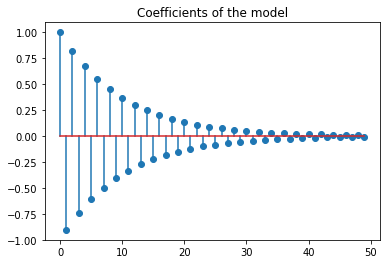

In [3]:
# Getting sparse coefficients
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model = (-1)**idx * np.exp(-idx / 10.)

# Reprezentation of the coefficients
plt.stem(x_model); 
plt.title("Coefficients of the model")

We generate a dataset for the logistic using the sparse coefficients above ($d = 50$ variables and $n = 10,000$ observations)

In [4]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation for the logistic

    Parameters
    ----------
    x : ndarray, shape (d,) - The coefficients of the model
    n : int - Sample size
    std : float, default=1. - Standard-deviation of the noise
    corr : float, default=0.5 - Correlation of the features matrix

    Returns
    -------
    A : ndarray, shape (n, d) - The design matrix.
    b : ndarray, shape (n,) - The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    
    return A, np.sign(b)

In [5]:
A, b = simu_logreg(x_model, n, std=1., corr=0.1)
print(A.shape)
print(b.shape)

(10000, 50)
(10000,)


In [6]:
A[10,:]

array([ 0.93443765,  1.53897766,  0.87883136,  0.32909696, -0.00312574,
        1.19904064,  0.84376087, -0.57428624, -0.72609293,  1.01055425,
        0.32244906, -0.38427615, -2.30057774, -2.11715015,  2.38524573,
       -1.53472855, -0.64382362, -0.59032009,  0.4171411 , -0.19287553,
       -0.68745019, -0.98440094, -0.83311087,  0.94571311,  0.2115075 ,
        0.83600399,  0.21443663, -0.53038224, -0.52368819, -0.9246443 ,
       -1.90857486, -1.63579176, -0.31101506,  0.31680811,  0.86527269,
        1.22465279,  0.64764891, -0.17165961, -0.48033534, -1.06956696,
        0.34459552, -0.27105369, -1.38155863, -1.12992918,  0.57070852,
        0.80647872,  1.33773964, -0.05558402,  1.03337773,  0.63466663])

<a id='sc'></a>

## 4. L-BFGS with scipy (without MapReduce)

In this section, we check that the gradient and the loss function of the "*class LogReg*" are correct. We also compute the minimum of the logistic loss function using Scipy.

In [7]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5) # default value

# Check that the gradient and the loss numerically match
check_grad(LogReg(A, b, lbda).loss, LogReg(A, b, lbda).grad, np.random.randn(d))

1.1563612654123882e-07

The *"grad"* function seems to be correct: the check_grad output is very small. 

In [8]:
from scipy.optimize import fmin_l_bfgs_b
# Initialization
x_init = [random.random() for i in range(d)] 
x_min, f_min, _ = fmin_l_bfgs_b(LogReg(A, b, lbda).loss, x_init, LogReg(A, b, lbda).grad, pgtol=1e-30, factr=1e-30)
print("\033[1mThe min of the logistic loss function is:  \033[0m", f_min)

The min of the logistic loss function is:   0.362237760275


<a id='algo1'></a>

## 5. L-BFGS with MapReduce

We now implement the L-BFGS algorithm with MapReduce using PySpark. We reproduce *"Algorithm 1"* and *"Algorithm 2"* of the paper ["*Large-scale L-BFGS using MapReduce*"](https://ai2-s2-pdfs.s3.amazonaws.com/2e07/77d0cd13f31f0abae97e824111c04e330f40.pdf). 

First of all, we create a Resilient Distributed Dataset (RDD). 

In [9]:
X = np.concatenate((np.array(b,ndmin=2).T,A), axis = 1)
data = sc.parallelize(X)
X.shape

(10000, 51)

In [11]:
# First entry
data.first()
# All the entries
#data.collect()

array([-1.        , -0.06645776,  1.27286674, -1.48701828, -0.23326064,
       -1.10796668,  1.23938816,  0.78096155,  0.43858165, -0.01083245,
       -0.19418369, -0.07592908, -0.51612939,  0.1111656 , -0.48210349,
        0.5902311 , -1.44742222, -0.77450085,  0.27834112,  0.85879126,
        0.16048755, -0.40092992,  1.77957102, -0.54408148, -0.5343709 ,
        1.62275196, -0.56146455,  0.31254364, -0.53210514, -0.97075471,
        0.60499511, -1.19801148, -1.86047898,  1.76080196, -0.8638364 ,
       -0.22273859, -1.84777344, -0.06935159,  0.73609321, -0.07875576,
       -0.88530925,  2.12849386, -0.15291241,  0.05251885, -0.81073761,
       -1.97074372, -0.21208668,  0.03700692,  0.6761332 , -0.27204531,
       -1.0154034 ])

**Map $\&$ Reduce methods:**

The map step takes each observation (each unit that can be treated independently) and applies some transformation to it. The reduction step then takes the results and does some sort of aggregation operation that returns a summary measure.


The computation of the gradient can be written as some iterations over a Map step and a Reduce step. More precisely, we can compute "partial" gradients on each row of the sample (*Map*) and we can aggregate these "partial" gradients to obtain a gloabal gradient vector (*Reduce*).

In [12]:
def gradient_rdd(matrix, x):
    """Return partial gradients that will be used later for computing the total gradient with MapReduce"""
    Y = matrix[0]
    X = matrix[1:]
    return ((1.0 / (1.0 + np.exp(-Y * X.dot(x))) - 1.0) * Y * X.T + [lbda * x[i] for i in range(len(x))] )

def add(x,y):
    x +=y
    return x

In [13]:
def L_bfgs(data, gradient_rdd, max_iter, step, x_init):
    """
    L-BFGS algorithm

    Parameters
    ----------
    data : RDD 
    gradient_rdd : function computing partial gradients (see above)
    max_iter : number of iterations
    step_value : step used to update the value of x
    x_init : ndarray, shape (d,) - The initialization of the coefficients of the model


    Returns
    -------
    x : ndarray, shape (d,) - The argmin of the loss function.

    """
    
    print("\033[1mRunning L-BFGS with %s iterations: \033[0m" % max_iter)
    print("The step used is %s" % step)
    
    # Initialization
    x = x_init
    d = len(x_init)
    m1 = 10 # m1 is the integer history size
    k = 0
    alpha = [1]
    
    # Gradient using MapReduce
    res = data.map(lambda m: gradient_rdd(m,x)).reduce(add)
    gradient_val = res
   
    s = np.array(x, ndmin=2).T # position difference initialization
    y = np.array(gradient_val, ndmin=2).T # gradient difference initialization 
    
    
    for nb_iter in range(0, max_iter):   
        # Search direction (parameter pk) (algorithm 2 in the paper)
        p_k = list(-gradient_val)
        for i in range(s.shape[1]):
            alpha[i]=s[:,i].T.dot(np.array(p_k,ndmin=2).T[:,0])/s[:,i].T.dot(y[:,i])
            p_k= [round(p_k[j]-alpha[i]*y[j,i],3) for j in range(d)]
        if k > 0:
            coeff=(s[:,0].T.dot(y[:,0])/y[:,0].T.dot(y[:,0]))
            p_k=[round(coeff*p_k[m],3) for m in range(len(p_k))]
        for j in range(s.shape[1]):
            b=y[:,k-1-j].T.dot(p_k)/s[:,k-1-j].T.dot(y[:,k-1-j])
            p_k=[round(p_k[m]+(alpha[k-1-j]-b)*s[m,k-1-j],3) for m in range(d)]
           
        # Compute the new value of x
        x = [x[m] + step * p_k[m] for m in range(d)]
         
        # Discard vector pairs s_k-m, y_k-m from memory storage
        if k > m1:
            s=np.delete(s,s.shape[1]-1,1)
            y=np.delete(y,y.shape[1]-1,1)
        else:
            k=k+1
        
        # Convergence check
        l_inf_norm_grad = np.max(np.abs(gradient_val))
        #print('iter: %d, l_inf_norm(grad): %.6g, f_min: %.6g'  %(nb_iter, l_inf_norm_grad, LogReg(A, b, lbda).loss(x)))
        if l_inf_norm_grad < 1e-6:
            break 
            
        # Compute gradient for n_iter + 1
        res = data.map(lambda m: gradient_rdd(m, x)).reduce(add)
        gradient1 = res
        
        # Update the position and gradient differences
        alpha+=[1]
        s = np.concatenate((np.array([step * p_k[m] for m in range(d)], ndmin=2).T,s), axis=1)
        y = np.concatenate((np.array((gradient1 - gradient_val), ndmin=2).T,y), axis=1)
        gradient_val = gradient1
        
    return x

In [14]:
start = time.time()
x_min_algo1 = L_bfgs(data, gradient_rdd, max_iter=50, step=0.33, x_init=x_init)
time1 = time.time() - start

print("The running time is %s " % time1)
f_min_algo1 = LogReg(A, b, lbda).loss(x_min_algo1)
print("The minimum is %s " % f_min_algo1)

Running L-BFGS with 50 iterations: 
The step used is 0.33
The running time is 144.9526400566101 
The minimum is 0.363747574983 


In [15]:
print("Distance to minimum", f_min - f_min_algo1)

Distance to minimum -0.00150981470759


**Comments:**

Our implementation gives a minimum that is very close to the "scipy" minimum. The running time is about 144.95 seconds (2.4 minutes).
In addition, L-BFGS has the advantage to maintain the historical states of previous $m1$ (we choose $m1=10$ in our algorithm) updates of current position $x$ and its gradient. The BFGS algorithm would have stored a dense $d*d$ ($d = 50$ in our case) matrix instead.


The two-loop recursion in the algorithm are used to compute the direction $p_k$ : it initalizes the direction $p_k$ with gradient and continues to update it using historical states $y$ and $s$. It requires $2m1 +1$ (i.e. 21) vectors and each of them has a length of $d$ (i.e. 50). 
When $d$ is in billion scale, either the storage or the computation cost becomes prohibitive and it makes it impractical to implement in MapReduce.

We need an algorithm that limits both the memory consumption and the number of MapReduce steps per iteration.



*Note: we could have computed a step size using a line search to satisfy the strong Wolfe conditions but we were satisfied with our default step size (0.33).*

<a id='algo2'></a>

## 6. VL-BFGS with MapReduce

We now implement the VL-BFGS algorithm.

The intuition behind the VL-BFGS algorithm is that $p_k$ can be represented as a linear combination of $y$, $s$ and $\nabla f(x)$. Let's define $(2m1+1)$ base vectors: 
- $b_1 = s_{k-m1}, b_2 = s_{k-m1+1},...., b_{m1} = s_{k-1}$
- $b_{m1+1} = y_{k-m},...b_{2m1} = y_{k-1}$
- $b_{2m1+1} = \nabla f(x_i)$.

$p$ is formalized as a linear combination of $b_i$ : $ p = \sum_{k=1}^{2m1+1} \delta_k b_k $   [1].


The dot product operations used for computing $p_k$ in the algorithm L-BFGS can be classified into two categories:
- the dot product between $(s_i, y_i)$ - we can pre-compute their dot product;
- the dot product involving $p$ - since the direction $p$ is changing during the for loop, the dot product cannot be pre computed. However, thanks to the linear decompositiohn of $p$ in [1], we can decompose any dot product involving $p_k$ into a summation of dot products with its based vectors and corresponding coefficients.

The VL-BFGS algorithm uses the dot products between every two base vectors as a scalar matrix of $(2m1 +1) *(2m1+1)$ scalars for computing the direction $p_k$. As the original L-BFGS algorithm, it has a two loop recursion but all the operations are only dependent on scalar operations (more details [here](https://ai2-s2-pdfs.s3.amazonaws.com/2e07/77d0cd13f31f0abae97e824111c04e330f40.pdf)).


In [16]:
def VL_bfgs(data, gradient_rdd, max_iter, step, x_init):
    """
    VL-BFGS algorithm

    Parameters
    ----------
    data : RDD 
    gradient_rdd : function computing partial gradients (see above)
    max_iter : number of iterations
    step_value : step used to update the value of x
    x_init : ndarray, shape (d,) - The initialization of the coefficients of the model


    Returns
    -------
    x : ndarray, shape (d,) - The argmin of the loss function.

    """
    
    print("\033[1mRunning VL-BFGS with %s iterations: \033[0m" % max_iter)
    print("The step used is %s" % step)
    
    # Initialization
    x = x_init
    d = len(x_init)
    
    m1 = 10 # m1 is the integer history size
    k = 1 
    alpha = [1]
    
    # Gradient using MapReduce
    res = data.map(lambda m: gradient_rdd(m,x)).reduce(add)
    gradient_val = res
   
    s = np.array(x, ndmin=2).T # position difference initialization
    y = np.array(gradient_val, ndmin=2).T # gradient difference initialization 
    
    matriceglobale1 = np.concatenate((np.array(gradient_val,ndmin=2).T,y,s),axis=1)
    matriceglobale1 = matriceglobale1[:,::-1]
    matriceglobale = matriceglobale1.T @ matriceglobale1

    
    for nb_iter in range(0, max_iter): 
        
        if k >= m1:
            # Search direction (parameter pk) - algorithm 3 of the paper
            delta = [0 if i<= 2*m1-1 else -1 for i in range(2*m1+1)]
            for i in reversed(range(k-m1,k)):
                j = i - (k-m1) + 1
                alpha[i] = sum([delta[l] * matriceglobale[l,j] for l in range(2*m1 + 1)]) / matriceglobale[j, m1+j]
                delta[m1+j] = delta[m1+j] - alpha[i]
            for i in range(2*m1+1):
                delta[i] = matriceglobale[m1,2*m1] * delta[i] / matriceglobale[2*m1, 2*m1]
            for i in range(k-m1,k):
                j = i-(k-m1)+1
                beta = sum([delta[l]*matriceglobale[m1+j,l] for l in range(2*m1+1)])/matriceglobale[j,m1+j]
                delta[j] = delta[j] + (alpha[i]-beta)        
            p_k = matriceglobale1.dot(np.array(delta, ndmin= 2).T)
            p_k = p_k / max(np.abs(p_k))
          
            # Compute the new value of x
            x = [x[m] + step * p_k[m,0] for m in range(d)]   # step = 0.33 bien
        
            # Discard vector pairs s_k-m, y_k-m from memory storage
            s=np.delete(s,s.shape[1]-1,1)
            y=np.delete(y,y.shape[1]-1,1)
  
        
        else : 
            # Search direction (parameter pk) - algorithm 3 of the paper
            delta = [0 if i<=2*k-1 else -1 for i in range(2*k+1)]
            for i in reversed(range(k)):
                j = i +1
                alpha[i] = sum([delta[l] * matriceglobale[l,j] for l in range(2*k+1)]) / matriceglobale[j,k+j]
                delta[k+j] = delta[k+j]-alpha[i]
            for i in range(2*k+1):
                delta[i] = matriceglobale[k,2*k] * delta[i]/matriceglobale[2*k,2*k]
            for i in range(k):
                j = i+1
                beta = sum([delta[l] * matriceglobale[k+j,l] for l in range(2*k+1)]) / matriceglobale[j,k+j]
                delta[j] = delta[j] + (alpha[i]-beta)
            p_k = matriceglobale1.dot(np.array(delta, ndmin= 2).T)
            p_k = p_k / max(np.abs(p_k))
           
            # Compute the new value of x
            x = [x[m] + step * p_k[m,0] for m in range(d)]   # step = 0.33 bien
            
        # Convergence check
        l_inf_norm_grad = np.max(np.abs(gradient_val))
        #print('iter: %d, l_inf_norm(grad): %.6g, f_min: %.6g'  %(nb_iter, l_inf_norm_grad, LogReg(A, b, lbda).loss(x)))
        if l_inf_norm_grad < 1e-6:
            break 
            
        # Compute gradient for n_iter + 1
        res = data.map(lambda m: gradient_rdd(m, x)).reduce(add)
        gradient1 = res
        
        # Update the position and gradient differences
        alpha += [1]
        s = np.concatenate((step*p_k,s), axis=1)
        y = np.concatenate((np.array((gradient1 - gradient_val), ndmin=2).T,y), axis=1)
        gradient_val = gradient1
        matriceglobale1=np.concatenate((np.array(gradient_val,ndmin=2).T,y,s),axis=1)
        matriceglobale1=matriceglobale1[:,::-1]
        matriceglobale = matriceglobale1.T @ matriceglobale1
        k=k+1
        
    return x

In [17]:
start = time.time()
x_min_algo2 = VL_bfgs(data, gradient_rdd, max_iter=50, step=0.33, x_init=x_init)
time2 = time.time() - start

print("The running time is %s " % time2)
f_min_algo2 = LogReg(A, b, lbda).loss(x_min_algo2)
print("The minimum is %s " % f_min_algo2)
print("Distance to minimum is", f_min - f_min_algo2)

Running VL-BFGS with 50 iterations: 
The step used is 0.33
The running time is 136.98225808143616 
The minimum is 0.762606504308 
Distance to minimum is -0.400368744033


**Comments:**

The L-BFGS and VL-BFGS algorithms are mathematically equivalent. However, since all calculations are based on salars, the VL-BFGS is more efficient. It requires only $8m1^2$ multiplications between scalar in the two for loops.
The running time of the algorithm is a bit smaller and equal to 136.98 seconds (2.3 minutes). However, the algorithm needs more iterations to converge to the minimum (50 is not enough) (or maybe we did something wrongly -- the way for obtaining the matrix dot product *"matriceglobale1"* was not detailed in the paper).


An alternative approach is to store $s$ and $y$ into multiple partitions and use a MapReduce step to calculate every dot product. We tried this approach but the *"Reduce"* step was very expensive in terms of running time (see below). It is the reason why we used the "@" operator for the calculation of the dot product matrix.
We give an example hereafter with a $3 \times 3$ matrix.

In [18]:
# Our initial (?)bad(?) idea: parallelization of the product matrix

import pandas as pd
def add(x,y):
    x +=y
    return x

def process_mat_row(row):
    index = int(row[0])
    values = [float(_) for _ in row[1:]]
    return [[index, j, v] for j, v in enumerate(values)]

def key_ij(row):
    return row[0], (row[1], row[2])
def key_ji(row):
    return row[1], (row[0], row[2])

def produit_matriciel(row):
    index, ((i, v1), (j, v2)) = row
    return i, j, v1 * v2

def produit(mat1, mat2):
        matrice1 = mat1.flatMap(process_mat_row)
        matrice2 = mat2.flatMap(process_mat_row)
        mat_join = matrice1.map(key_ji).join(matrice2.map(key_ij))
        produit = mat_join.map(produit_matriciel)
        final = produit.map(lambda row:((row[1],row[0]), row[2])).reduceByKey(add).reduce(add)
        return(final)

In [19]:
# Test with 3*3 Matrix
mat1 = np.array([[0,1,2,3],[1,4,5,6],[2,2,3,4]])
mat2 = np.array([[0,1,4,2],[1,2,5,3],[2,3,6,4]])
print(mat1)
print(mat2)
mat1 = sc.parallelize(mat1)
mat2 = sc.parallelize(mat2)

start = time.time()
u = produit(mat1,mat2)
# Sort the elements
u1 = np.zeros((3,3))
for i in range(int(len(u)/2)):
    u1[u[2*i][0],u[2*i][1]]=u[2*i+1]
time_need = time.time() - start
print("Matrix product")
print(u1)
print("Running time for a 3*3 matrix : ", time_need)

[[0 1 2 3]
 [1 4 5 6]
 [2 2 3 4]]
[[0 1 4 2]
 [1 2 5 3]
 [2 3 6 4]]
Matrix product
[[ 14.  32.  20.]
 [ 32.  77.  47.]
 [ 20.  47.  29.]]
Running time for a 3*3 matrix :  12.800367832183838


<a id='conc'></a>
## 7. Conclusion

**Comparison of the L-BFGS and VL-BFGS algorithms (50 iterations, 50 variables, 10,000 observations):**


| Algorithm     | F_min         | Running time |
| ------------- |:-------------:| ------------:|
| Scipy         | 0.36          |      -       |
| L-BFGS        | 0.36          |   144.95     |
| VL-BFGS       | 0.76          |   136.98     |


To conclude the VL-BFGS algorithm enables a variety of machine learning algorithms to handle a massive number of variables over large datasets. 

The better scalability property of the VL-BFGS seems negligible with our implementation because we took a very small number of variables (50) and we ran MapReduce locally. The autors of the [paper](https://ai2-s2-pdfs.s3.amazonaws.com/2e07/77d0cd13f31f0abae97e824111c04e330f40.pdf) have shown a huge performance improvement with the VL-BFGS using 1,038,934,683 features and running the experiment in a shared cluster with tens of thousands of machines (each of the machine had up to 12 concurrent vertices).

Note that we consider as use-case a logistic regression with ridge penalization only, although the algorithms above can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization (requires to use the proximal operator instead of the gradient).
